In [1]:
import numpy as np
import pandas as pd
import os
from collections import defaultdict

### Globals

In [2]:
OUTPUT_PATH = 'outputs/'
FEATURES_PATH = 'features/'
ALGORITHMS = ['bf', 'dp1','greedy', 'bnb', 'cplex']
LEVELS = [1,2]#,3,4]#5,6,7,8]
LEVELS_SIZE = [19198 ,9983, 6664, 4994]#, 3999, 3333, 2857, 2500]
FEATURES = ['num_elem',
            'cap',
            'cap_mean_w',
            'cap_median_w', 
            'cap_desv_w', 
            'mean_w_mean_v',
            'median_w_median_v', 
            'desv_w_desv_v',
            'max_w_min_w',
            'max_v_min_v',
            'mean_w',
            'median_w', 
            'desv_w', 
            'min_w', 
            'max_w', 
            'mean_v', 
            'median_v', 
            'desv_v', 
            'min_v', 
            'max_v',
            'p_coef' 
           ]

### Helpers

In [3]:
def get_features(lvl, id_):
    return np.array(open(FEATURES_PATH +str(lvl)+'/'+ str(id_),'r').read().split(), dtype=float)

def get_best(lvl, id_, t):
    best_fo = 0
    best_alg = 0
    best_time = 900000
    for alg in ALGORITHMS:
        if lvl not in alg_data[alg].keys(): continue
        if id_ not in alg_data[alg][lvl].keys(): continue
        for res in alg_data[alg][lvl][id_]:
            if res[1] < t:
                if res[0] > best_fo:
                    best_fo = res[0]
                    best_time = res[1]
                    best_alg = ALGORITHMS.index(alg)
                
                elif res[0] == best_fo and res[1] < best_time:
                    best_time = res[1]
                    best_alg = ALGORITHMS.index(alg)
    return best_alg+1

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(6), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    plt.xticks(np.arange(6), ["NA",*ALGORITHMS])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

### Reading outputs

In [5]:
output_files = os.listdir(OUTPUT_PATH)
alg_data = defaultdict(list)

print("Faltan los siguientes resultados:")
for alg in ALGORITHMS:
    alg_data[alg] = defaultdict(list)
    for lvl in LEVELS:
        filename = alg + "_" + str(lvl)
        if filename not in output_files: # En caso de que todavía no hayan resultados
            print(alg, lvl)
            continue
        alg_data[alg][lvl] = defaultdict(list)
        file = open(OUTPUT_PATH+filename,'r')
        for row in file:
            id_, fo, time = row.split()
            alg_data[alg][lvl][int(id_)].append([(float)(fo), (float)(time)])

Faltan los siguientes resultados:


In [10]:
timesteps = np.logspace(1, 18.4, num=6, base=1.1)-1.1 # escala logaritmica para los tiempos
print(timesteps)
timesteps = timesteps[1:]
timesteps

[0.         0.43263673 1.03543213 1.87531066 3.04551855 4.67597636]


array([0.43263673, 1.03543213, 1.87531066, 3.04551855, 4.67597636])

In [11]:
train_data = []
train_label = []

count = 0

for lvl in LEVELS:
    print("level "+str(lvl)+"...")
    for id_ in range(LEVELS_SIZE[lvl-1]):
        fts = get_features(lvl, id_)
        for t in timesteps:
            train_data.append([*fts, t+1])
            train_label.append(get_best(lvl, id_, t))
        count += 1

level 1...
level 2...


#### Standard Scale: mean=0 and std=1

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
strain_data = scaler.fit_transform(train_data)

#### or... between 0 and 1

In [13]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
strain_data = min_max_scaler.fit_transform(train_data)

# LSTM

In [26]:
import tensorflow as tf
from keras.layers import Dropout, Dense, LSTM
from keras import Sequential
from keras import optimizers
from keras.models import Model   
from keras.layers import *
import keras
# Helper libraries
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras import backend as K

In [16]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [123]:
X_train, X_test, y_train, y_test = train_test_split(strain_data, train_label, test_size=0.3, random_state=42)

In [127]:
length = 22
X_train = X_train.reshape(X_train.shape[0], 1, length)
y_train = to_categorical(y_train)
y_train = y_train.reshape(y_train.shape[0],1, 6)
X_test = X_test.reshape(X_test.shape[0], 1, length)
y_test = to_categorical(y_test)
y_test =  y_test.reshape(y_test.shape[0], 1,6)

In [128]:
y_train.shape, X_train.shape

((102133, 1, 6), (102133, 1, 22))

In [110]:
model= Sequential([
                LSTM(length,
                input_shape=(1,22),
                return_sequences=True),
                Dropout(0.2),
                LSTM(128,
                return_sequences=True),
                Dropout(0.2),
                LSTM(128,
                return_sequences=True),
                Dropout(0.2),
                LSTM(64,
                return_sequences=True),
                Dropout(0.2),
                Dense(output_dim=6),
                Activation('sigmoid')
                ])
"""
model = Sequential()
model.add(LSTM((1),batch_input_shape=(None, 5, 1),return_sequences=False))
"""

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=6)`


'\nmodel = Sequential()\nmodel.add(LSTM((1),batch_input_shape=(None, 5, 1),return_sequences=False))\n'

In [111]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',f1])

In [112]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_127 (LSTM)              (None, 1, 22)             3960      
_________________________________________________________________
dropout_106 (Dropout)        (None, 1, 22)             0         
_________________________________________________________________
lstm_128 (LSTM)              (None, 1, 128)            77312     
_________________________________________________________________
dropout_107 (Dropout)        (None, 1, 128)            0         
_________________________________________________________________
lstm_129 (LSTM)              (None, 1, 128)            131584    
_________________________________________________________________
dropout_108 (Dropout)        (None, 1, 128)            0         
_________________________________________________________________
lstm_130 (LSTM)              (None, 1, 64)             49408     
__________

In [129]:
history = model.fit(X_train,y_train, 
                    epochs=10,
                    batch_size = 64,
                    validation_split=0.3)

Train on 71493 samples, validate on 30640 samples
Epoch 1/10
71493/71493 [==============================] - 47s 664us/step - loss: 0.8998 - acc: 0.4720 - f1: 0.6161 - val_loss: 0.8326 - val_acc: 0.4826 - val_f1: 0.6225
Epoch 2/10
71493/71493 [==============================] - 43s 605us/step - loss: 0.8321 - acc: 0.4806 - f1: 0.6227 - val_loss: 0.8104 - val_acc: 0.5250 - val_f1: 0.6319
Epoch 3/10
71493/71493 [==============================] - 41s 578us/step - loss: 0.8053 - acc: 0.5487 - f1: 0.6350 - val_loss: 0.8046 - val_acc: 0.5641 - val_f1: 0.6381
Epoch 4/10
71493/71493 [==============================] - 43s 595us/step - loss: 0.7943 - acc: 0.5623 - f1: 0.6369 - val_loss: 0.7828 - val_acc: 0.5701 - val_f1: 0.6416
Epoch 5/10
71493/71493 [==============================] - 44s 612us/step - loss: 0.7853 - acc: 0.5679 - f1: 0.6399 - val_loss: 0.7717 - val_acc: 0.5766 - val_f1: 0.6489
Epoch 6/10
71493/71493 [==============================] - 44s 610us/step - loss: 0.7776 - acc: 0.5737 - f

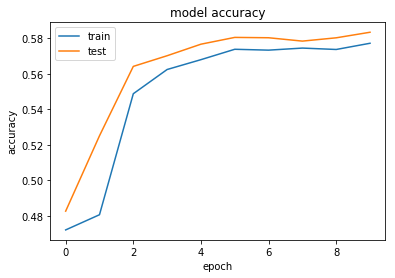

In [130]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

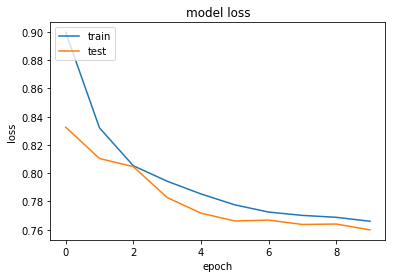

In [131]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()